In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute

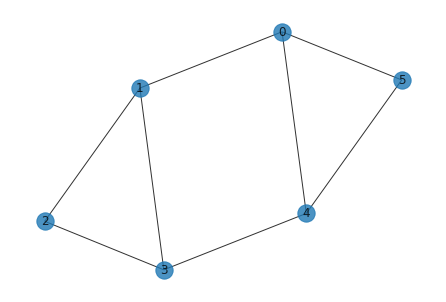

In [2]:
edges = [(0,1), (1,2), (2,3), (3,4), (4,0), (1,3), (0,5), (4,5)]
G = nx.Graph(edges)
nx.draw(G, with_labels=True, alpha=0.8)

In [3]:
def maxcut_obj(x, G):
    # x is the input bit string
    # Output will be the maxcut function value using x bit string
    obj = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            obj -= 1
    return obj

In [4]:
def compute_expectation(counts, G):
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        obj = maxcut_obj(bitstring, G)
        avg += obj * count
        sum_count += count
    return avg/sum_count

In [5]:
# BASIC QAOA FROM HERE

def create_qaoa_circ(G, theta):
    nqubits = len(G.nodes())
    nlayers = len(theta)//2  # number of alternating unitaries
    beta = theta[:nlayers]
    gamma = theta[nlayers:]

    qc = QuantumCircuit(nqubits)

    # initial_state
    qc.h(range(nqubits))

    for irep in range(nlayers):
        # problem unitary
        for pair in list(G.edges()):
            qc.rzz(2 * gamma[irep], pair[0], pair[1])
        # mixer unitary
        for qubit in range(nqubits):
            qc.rx(2 * beta[irep], qubit)

    qc.measure_all()
    return qc

def get_expectation_QAOA(graph, shots=512):
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    def execute_circ(theta):
        qc = create_qaoa_circ(graph, theta)
        counts = backend.run(qc, seed_simulator=10,
                             nshots=512).result().get_counts()
        return compute_expectation(counts, graph)
    return execute_circ

In [6]:
# MULTI-ANGLE QAOA FROM HERE

def create_maqaoa_circ(G, theta):
    nqubits = len(G.nodes()) 
    qc = QuantumCircuit(nqubits)
    clauses = len(G.edges())
    nlayers = len(theta)//(nqubits+clauses)
    beta = np.reshape(theta[:nlayers*nqubits], (nlayers,nqubits))
    gamma = np.reshape(theta[nlayers*nqubits:], (nlayers,clauses))
    
    for i in range(nqubits):
        qc.h(i)
    
    for irep in range(nlayers):
        k=0
        # problem unitary
        for pair in list(G.edges()):
            qc.rzz(2 * gamma[irep,k], pair[0], pair[1])
            k+=1
        # mixer unitary
        for i in range(nqubits):
            qc.rx(2 * beta[irep,i], i)
        
    qc.measure_all()
    return qc

def get_expectation_MAQAOA(G, shots=512):
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        
        qc = create_maqaoa_circ(G, theta)
        counts = backend.run(qc, seed_simulator=10, nshots=512).result().get_counts()
        return compute_expectation(counts, G)
    
    return execute_circ

In [81]:
# BASIC QAOA FROM HERE

Basic QAOA


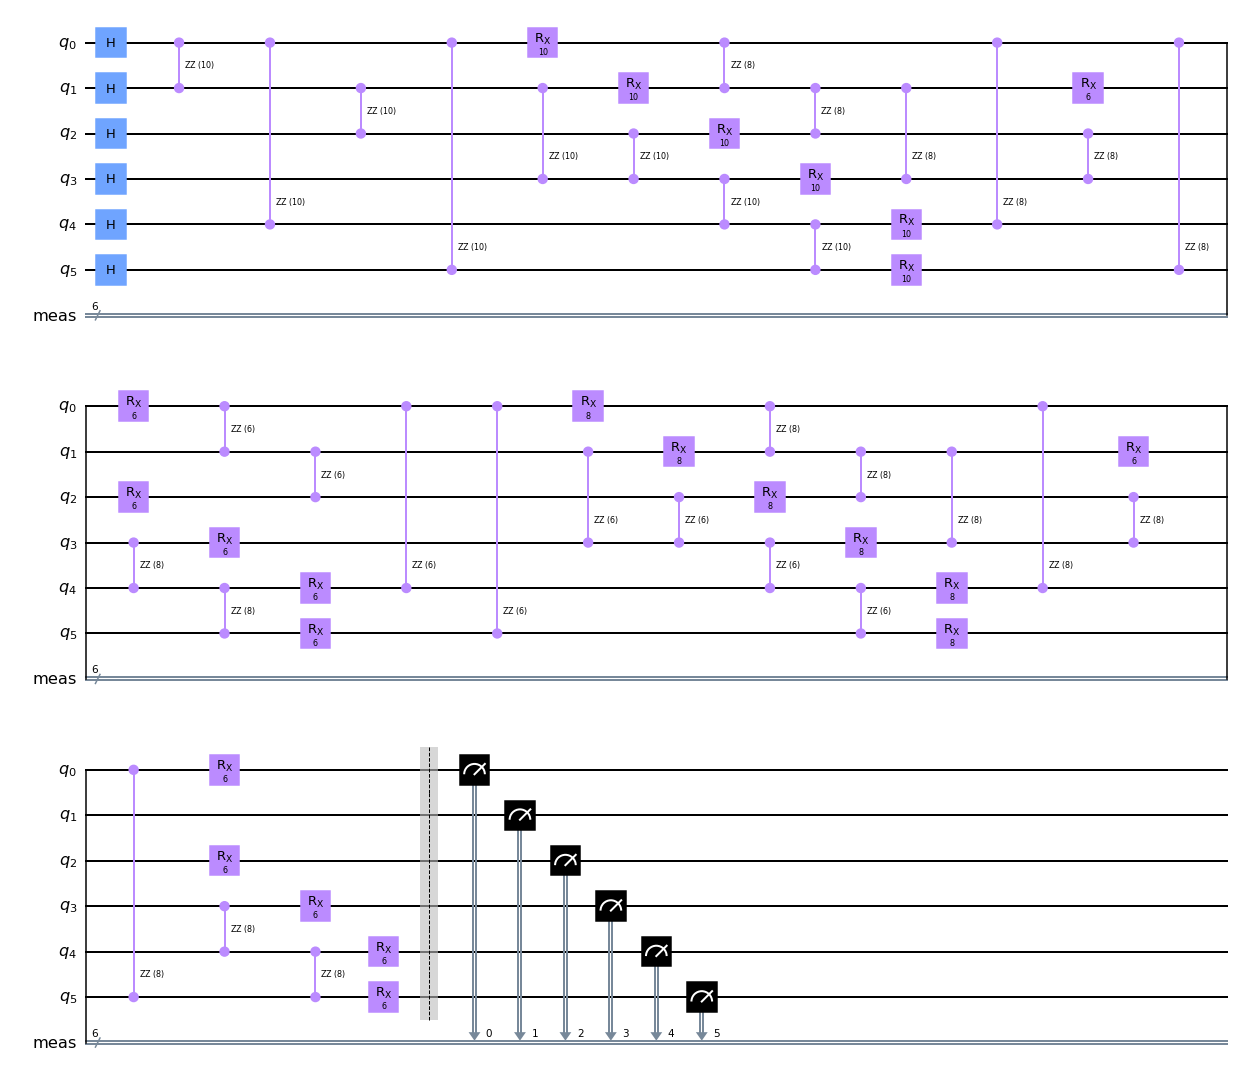

In [7]:
# Adding Parameters
theta = [5,3,4,3,5,4,3,4]
print("Basic QAOA")
qc = create_qaoa_circ(G, theta)
qc.draw()

In [8]:
from scipy.optimize import minimize
expectation = get_expectation_QAOA(G)
res = minimize(expectation, theta, method='COBYLA')
print("Basic QAOA")
res

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Basic QAOA


     fun: -5.412109375
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 107
  status: 1
 success: True
       x: array([5.36096334, 4.64016326, 3.53114023, 2.86649316, 4.94652302,
       3.97490282, 2.88741461, 4.2451118 ])

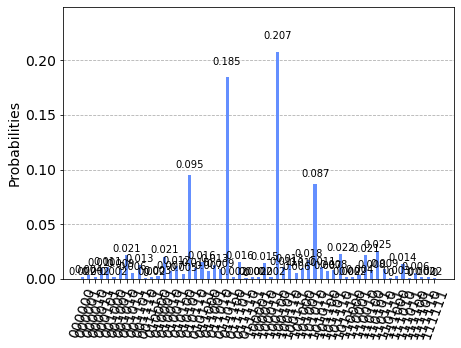

In [9]:
from qiskit.visualization import plot_histogram

backend = Aer.get_backend('aer_simulator')
backend.shots = 512

qc_res = create_qaoa_circ(G, res.x)
counts = backend.run(qc_res, seed_simulator=10).result().get_counts()
plot_histogram(counts)

In [87]:
# MULTI-ANGLE QAOA FROM HERE

Multi-Angle QAOA


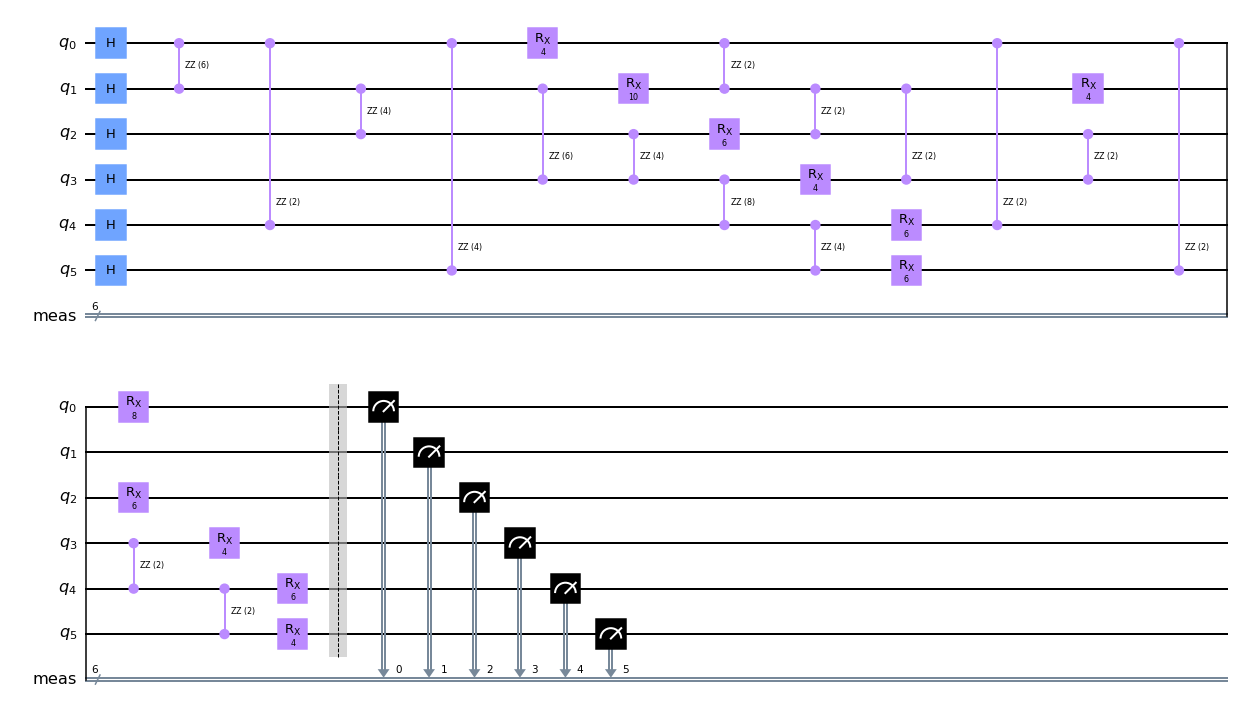

In [10]:
# Adding Parameters
beta = np.array([[2,5,3,2,3,3],[4,2,3,2,3,2]]) #Edit as per the number of qubits
gamma = np.array([[3,1,2,2,3,2,4,2],[1,1,1,1,1,1,1,1]]) #Edit as per the number of clauses
theta = np.concatenate((beta.flatten(), gamma.flatten()))
print("Multi-Angle QAOA")
qc = create_maqaoa_circ(G, theta)
qc.draw()

In [11]:
from scipy.optimize import minimize
expectation = get_expectation_MAQAOA(G)
res = minimize(expectation, theta, method='COBYLA')
res

     fun: -5.9794921875
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 358
  status: 1
 success: True
       x: array([1.13185357, 4.62227724, 2.34753593, 2.37782092, 2.85133515,
       4.05191967, 4.36073611, 1.6421531 , 3.07638959, 1.39905666,
       3.02497146, 2.08784568, 2.76298546, 0.83797665, 1.63534272,
       2.43215864, 2.60682252, 1.47016324, 3.22214198, 1.83330292,
       0.83140864, 1.62066334, 1.3479656 , 2.34154695, 1.91722047,
       1.17516658, 0.53241157, 2.23119738])

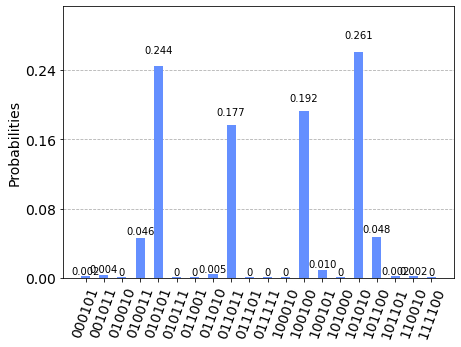

In [12]:
from qiskit.visualization import plot_histogram

backend = Aer.get_backend('aer_simulator')
backend.shots = 512

qc_res = create_maqaoa_circ(G, res.x)
counts = backend.run(qc_res, seed_simulator=10).result().get_counts()
plot_histogram(counts)